In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="This documment is written in a Jupyter notebook and the code used to produce these analyses has been hidden for ease of reading.  
To make the code visiable click here"></form>''')

### <center> What we need from Python: The Libraries
___

 - `numpy` to handle sample sets
 
    - `random` subpackage to generate random samples of various distributions.

 - `scipy.stats`

    - A standard kernel density estimator to approximate densities on sample sets.

    - Evaluate some standard density functions (e.g., normal) on sample sets.

 - `matplotlib.pyplot` to visualize results.
    
 - [`LUQ`](https://github.com/CU-Denver-UQ/LUQ) - But we will just use some `sklearn` packages directly in this notebook.

In [1]:
# The libraries we will use for part 1 of talk
import numpy as np
from scipy.stats import norm, uniform # The standard Normal distribution
from scipy.stats import gaussian_kde as kde # A standard kernel density estimator
import scipy.io as sio 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams.update({'figure.max_open_warning': 0})   #remove warning of so many open figures

In [2]:
# For more interactive visualizations (not always used in every presentation)
%matplotlib notebook
from scipy.optimize import bisect #Used much later -- don't worry about it
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## <center> Learning Quantities of Interest from Dynamical Systems for Observation-Consistent Inversion</center>
___
    
<font color='blue'><center>**T. Butler**</center></font>
<center>Co-authors: S. Mattis, K. Steffen, C. Dawson, and D. Estep</center></font>
    <br>
    <center>University of Colorado Denver
    <br>
    troy.butler@ucdenver.edu</center>

___

    
[***Learning Quantities of Interest from Dynamical Systems for Observation-Consistent Inversion***](https://arxiv.org/abs/2009.06918), Steven Mattis, Kyle Robert Steffen, Troy Butler, Clint N. Dawson, Donald Estep, arXiv:2009.06918v2

### <center>Some references for the density-based approach
---

- [***Combining Push-Forward Measures and Bayes' Rule to Construct Consistent Solutions to Stochastic Inverse Problems***](https://epubs.siam.org/doi/abs/10.1137/16M1087229), T. Butler, J. Jakeman, T. Wildey, SIAM J. Sci. Comput., 40(2), A984–A1011 (2018)


- [***Convergence of Probability Densities using Approximate Models for Forward and Inverse Problems in Uncertainty Quantification***](https://epubs.siam.org/doi/abs/10.1137/18M1181675), T. Butler, J. Jakeman, T. Wildey, SIAM J. Sci. Comput., 40(5), A3523–A3548. (2018)


- [***Data-consistent inversion for stochastic input-to-output maps***](https://iopscience.iop.org/article/10.1088/1361-6420/ab8f83), T. Butler, T. Wildey, T.Y. Yen, Inverse Problems, 36, 085015, (2020)


- [***Convergence of Probability Densities using Approximate Models for Forward and Inverse Problems in Uncertainty Quantification: Extensions to $L^p$***](http://arxiv.org/abs/2001.04369), T. Butler, T. Wildey, W. Zhang, arXiv:2001.04369

### <center> Some related presentations
---
    
- S. Mattis, *Learning Uncertain Quantities of Interest from Dynamical Systems*, MS46: Inference and Uncertainty quantification for computer models
<br>

- W. Zhang, *86 - Minisymposterium: Surrogate Model Constructed using Neural Networks for the Forward and Inverse Problems*
<br>

- T.Y. Yen, *Impacts of Finite Data and Distributional Estimation on Data Consistent Inversion*, MS339: Computational Techniques for Uncertainty Quantification in Large-scale Inverse Problems - Part II of II
<br>

- D. Estep, *Inverse Problems in Computational Probability*, Part II of II of this MS354.

## <center> Why use Jupyter notebooks? It keeps me honest.
___

<center><img src="figures/dt160106.gif" width=70%>

### <center> There is more to this notebook than what is shown in the presentation.
    
You are invited to explore this notebook at https://github.com/CU-Denver-UQ/LUQ.

### <center> Some perspective (thanks Mark Twain!)
___
    

* Facts are stubborn, but statistics are more pliable.


* Most people use statistics like a drunk man uses a lamppost; more for support than illumination.


* <font color='blue'>***Data is like garbage. You'd better know what you are going to do with it before you collect it.***</font>

### <center> Building Intuition
___
    
<center><img src="figures/inf_pred_cartoon.png" width=70%>

### <center> A Motivating Example: "Cooking" a T-Bone
___

Step 1: Build a 3D model (5341 DOF, 23498 tetrahedral elements).

<center><video controls src="T-bone-mesh.mp4"/>

Step 2: Determine thermal transfer properties of meat, bone, metal skillets, heated air, and typical temperature settings of stove tops.


Step 3: Follow (i.e., code) directions given by Omaha Steaks!

### <center> A Motivating Example: "Cooking" a T-Bone
___

Representative steak simulated: Rare (blue), Medium rare (red), Medium-to-well done (brown)

<center><video controls src="T-bone-medium-rare.mp4"/>

### <center> The Snowflake (not millenials) Analogy 
___
    

* Thermal properties are <font color='blue'>uncertain</font> due to natural variability in livestock. 


* <font color = 'blue'>Quantifying uncertainties</font> in the thermal properties enables us to cook steaks more reliably to their desired doneness. 

* Initial guesses of variability in thermal diffusivities of proten vs. bone will lead to some prediction of the distribution of final cooking temperatures.


* Actual cooking temperatures from experiments are likely to follow a different distribution because initial guesses and predictions are typically wrong. 


* How do we reconcile these differences between what is observed and what is predicted to update initial distributions to be consistent with the data?

<center><img src="figures/t_bone_all_in_one.png" width=70%/> 

### <center> Notation and Terminology
___

 * $\lambda\in\Lambda$ = model inputs referred to as <font color='blue'>model parameters.</font>
 
 
 * $Q(\lambda)$ = measurable model outputs referred to as <font color='blue'>quantities of interest (QoI).</font>
 
 
 * $\mathcal{D} = Q(\Lambda)$ denotes the set of observable data that can be <font color='red'>predicted by the model</font>.
 <br>
 
     * $q$ is used to denote a single datum.

### <center> Defining the problem and solution
___
Given a probability measure $P_\mathcal{D}^{obs}$ on $\mathcal{D}$ (described as density $\pi_\mathcal{D}^{obs}$) describing uncertainty in observed data, determine a probability measure $P_\Lambda$ on $\Lambda$ (described as density $\pi_\Lambda$) that is <font color='purple'>***consistent***</font> with both the model and observed data. 

   
Consistency means the <font color='blue'>***push-forward measure*** of $P_\Lambda$ through the QoI map $Q(\lambda)$ matches the probability measure given on $\mathcal{D}$. 

In other words, we want $P_\Lambda$ to be a <font color='blue'>***pullback measure.***</font>

To do this, we utilize the <font color='blue'>***push-forward of a initial $\pi_\Lambda^{initial}(\lambda)$ on $\Lambda$***</font>:

 
 * $\pi_{\mathcal{D}}^{predict}$ denotes the push-forward of the initial.
 
     * Represents a initial ***prediction*** of the relative likelihood of model outputs.

### <center> A pullback density: Existence, Uniqueness (up to initial), and Stability
___
$$
  \large \pi_\Lambda(\lambda) = \pi_\Lambda^{initial}(\lambda) \frac{\pi_{\mathcal{D}}^{obs}(Q(\lambda))}{\pi_{\mathcal{D}}^{predict}(Q(\lambda))} 
$$


* Solving a <font color='blue'>***forward UQ problem***</font> to approximate $\pi_{\mathcal{D}}^{predict}$ provides <font color='blue'>***sufficient***</font> information to <font color='blue'>***uniquely define***</font> $\pi_\Lambda$.


* **<font color='purple'>Predictability Assumption</font>**: $\exists$ $C>0$ such that $\pi_{\mathcal{D}}^{obs}(q) \leq C\pi_{\mathcal{D}}^{predict}(q)$ for a.e. $q\in\mathcal{D}$.


* $\pi_\Lambda$ is <font color='blue'>***stable***</font> (in the TV-metric) w.r.t. perturbations in $\pi_\Lambda^{initial}$ and $\pi_{\mathcal{D}}^{obs}$.


* The error in the approximate $\pi_\Lambda$ is bounded by the error in the approximate $\pi_{\mathcal{D}}^{predict}$ , i.e., the approximations are <font color='blue'>***numerically stable.***</font> 

### <center> Role of the set-valued inverses
___
$$
  \large \pi_\Lambda(\lambda) = \pi_\Lambda^{initial}(\lambda) \frac{\pi_{\mathcal{D}}^{obs}(Q(\lambda))}{\pi_{\mathcal{D}}^{predict}(Q(\lambda))} 
$$
    
* $\pi_{\mathcal{D}}^{predict}$ and $\pi_{\mathcal{D}}^{obs}(Q(\lambda))$ are <font color='blue'>***constant*** on each set-valued inverse $Q^{-1}(q)$.</font>


* $\pi_\Lambda^{initial}(\lambda)$ serves to regularize the pullback only <font color='blue'>***along*** on each set-valued inverse $Q^{-1}(q)$.</font>


* <font color='purple'>$\pi_\Lambda(\lambda)$ is an update to $\pi_\Lambda^{initial}(\lambda)$ only in directions locally orthogonal to set-valued inverses. </font>


### <center> A simple example in Python: The Spaces, QoI, and Densities
___


* $\Lambda=[-1,1]$.

* $Q(\lambda) = \lambda^p$ for $p=5$.

* $\mathcal{D} = Q(\Lambda) = [-1,1]$.

___

* $\pi_{\Lambda}^{initial} \sim U([-1,1])$

* $\pi_{\mathcal{D}}^{obs} \sim N(\mu,\sigma^2)$
    * Initially take $\mu=0.25$ and $\sigma=0.1$.

* $\pi_{\mathcal{D}}^{predict}$ 
    * Known in this case.

In [3]:
def QoI(lam,p): # defing a QoI mapping function
    q = lam**p
    return q

In [4]:
N, mu, sigma = int(1E4), 0.25, 0.1 # number of samples from initial and observed mean (mu) and st. dev (sigma)
lam = np.random.uniform(low=-1,high=1,size=N) # sample set of the initial

# Evaluate the QoI map on this initial sample set
qvals_nonlinear = QoI(lam,5) # Evaluate lam^5 samples

# Estimate the push-forward density for the QoI
q_nonlinear_kde = kde( qvals_nonlinear )

<IPython.core.display.Javascript object>


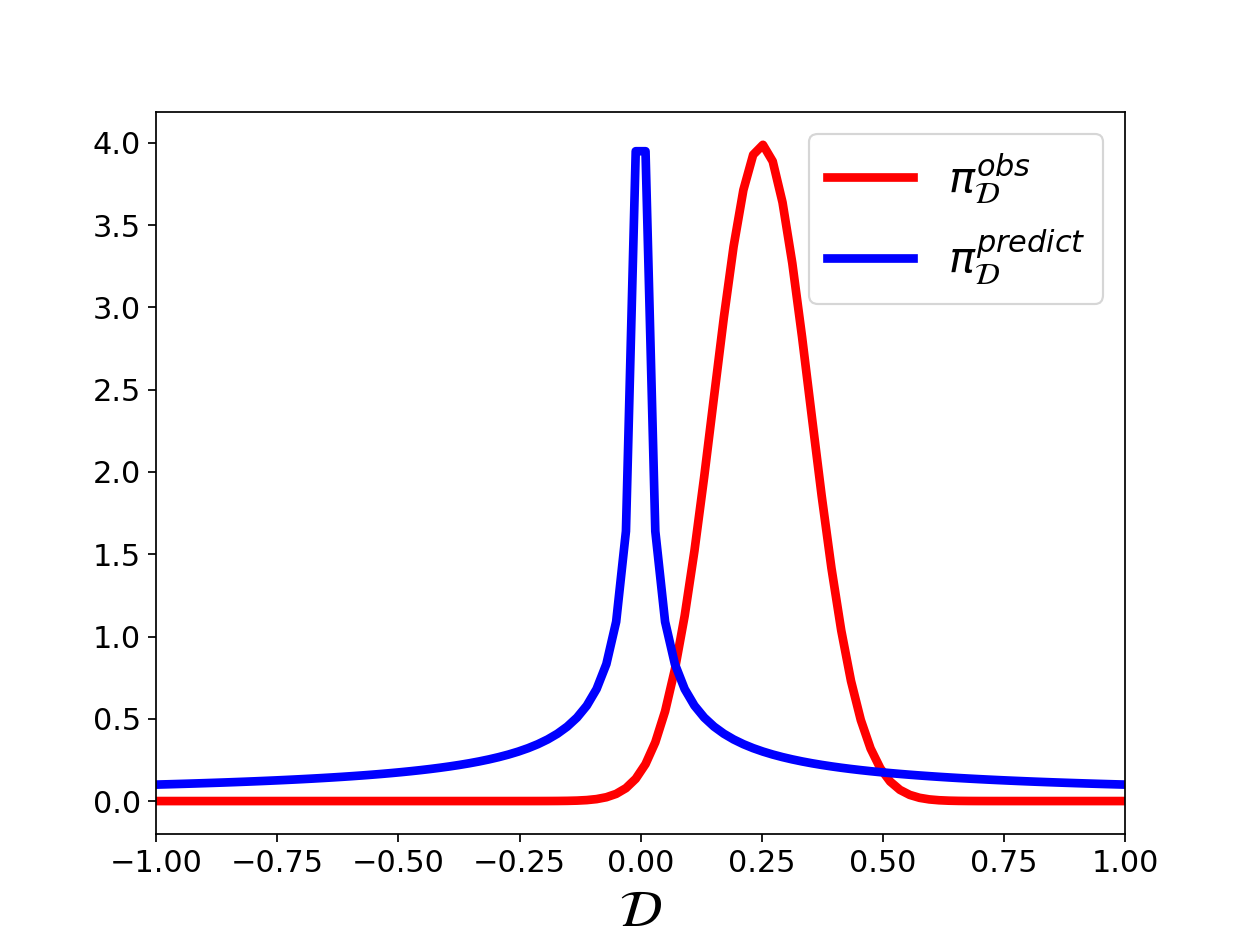

In [5]:
fig = plt.figure(figsize=(8,6)) # Plot the push-forward of the initial and observed densities
qplot = np.linspace(-1,1, num=100)
observed_plot = plt.plot(qplot,norm.pdf(qplot, loc=mu, scale=sigma), 'r-', linewidth=4, label="$\pi_\mathcal{D}^{obs}$")
pf_initial_plot = plt.plot(qplot,1/10*np.abs(qplot)**(-4/5),'b-', linewidth=4, label="$\pi_\mathcal{D}^{predict}$")

plt.xlim([-1,1]), plt.xticks(fontsize=14), plt.yticks(fontsize=14),plt.xlabel("$\mathcal{D}$", fontsize=24), plt.legend(fontsize=20), plt.show();

<IPython.core.display.Javascript object>


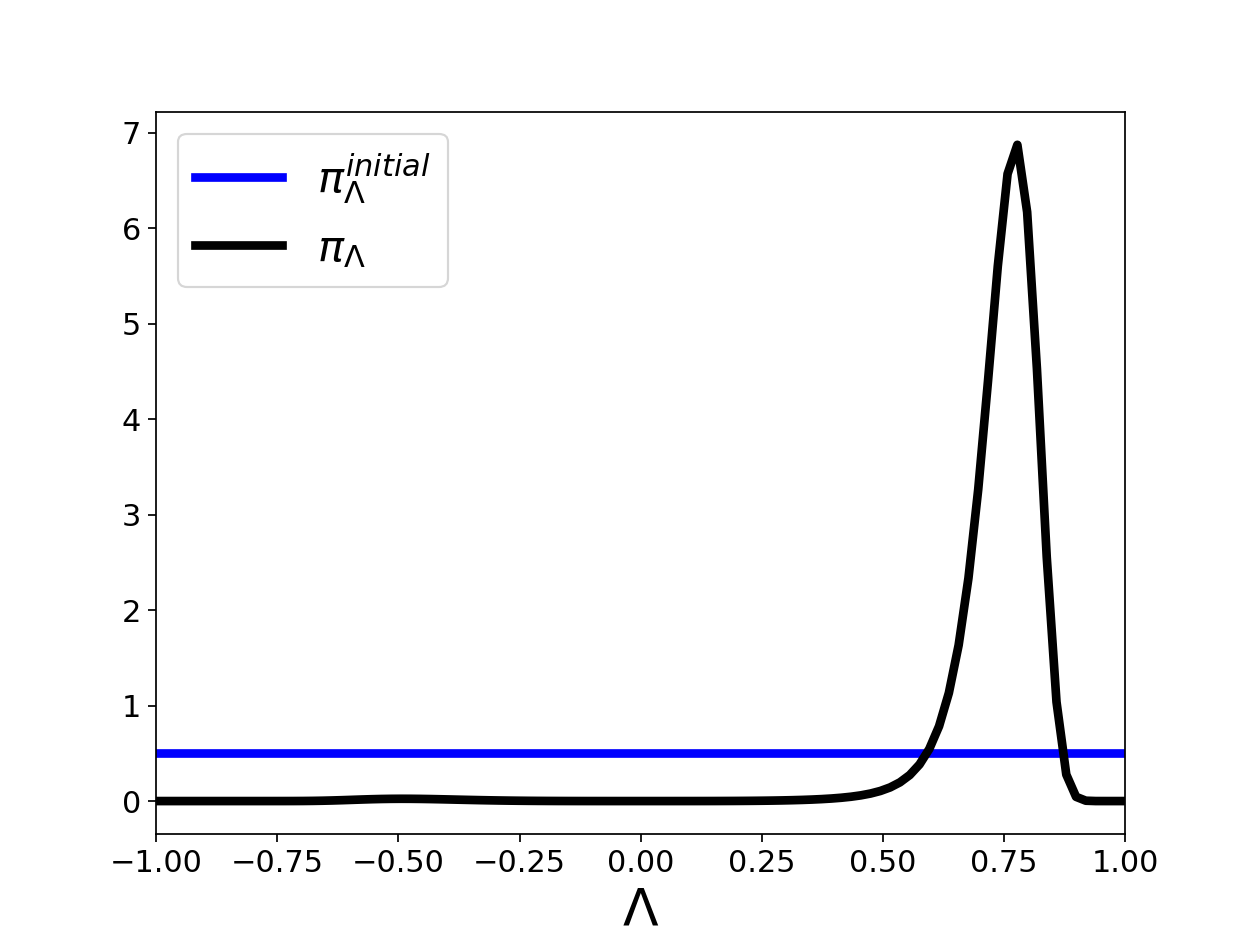

In [6]:
fig = plt.figure(figsize=(8,6)) # Plot the initial and posterior
lam_plot = np.linspace(-1,1, num=100)
initial_plot = plt.plot(lam_plot,uniform.pdf(qplot, loc=-1, scale=2), 'b-', linewidth=4, label="$\pi_\Lambda^{initial}$")
pullback_plot = plt.plot(lam_plot,uniform.pdf(qplot, loc=-1, scale=2)*\
                         norm.pdf(QoI(lam_plot,5), loc=mu, scale=sigma)/(1/10*np.abs(QoI(lam_plot,5))**(-4/5)),'k-', linewidth=4, label="$\pi_\Lambda$")
plt.xlim([-1,1]), plt.xticks(fontsize=14), plt.yticks(fontsize=14), plt.xlabel("$\Lambda$",fontsize=24), plt.legend(fontsize=20), plt.show();

### <center> A simple example in Python: Approximations and Sampling $\pi_\Lambda$
___


* **<font color='purple'>Goal:</font>** Use initial samples to generate samples from $\pi_\Lambda$. 

#### Investigate  [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling):
___
**<font color='purple'>Goal:</font>** Use samples from a random variable with density $g$ to generate samples from a random variable with density $f$. 


**<font color='purple'>Requirement:</font>** There exists $M>0$ such that $f(x)\leq M g(x)$ for all $x$. 

**<font color='purple'>Algorithm:</font>**
For proposed sample $y$ from $g$ 
* Generate sample $u \sim \mathrm {Unif} (0,1)$.
* If $u<f(y)/Mg(y)$, <font color='blue'>accept</font> $y$ as sample from $f$, otherwise reject.

### <center> A simple example in Python: Sampling $\pi_\Lambda$
___
**<font color='purple'>Rejection sampling for $\pi_\Lambda$?</font>**
    
$g=\pi_\Lambda^{initial}$ and $f=\pi_\Lambda$, so can use rejection sampling if there exists $M>0$ s.t.
$$
    \pi_\Lambda^{initial}(\lambda) \frac{\pi_{\mathcal{D}}^{obs}(Q(\lambda))}{\pi_{\mathcal{D}}^{predict}(Q(\lambda))} \leq M \pi_\Lambda^{initial}(\lambda).
$$

**<font color='purple'>Some manipulations and an observation</font>**

Divide through by the $\pi_\Lambda^{initial}$ and multiply by $\pi_{\mathcal{D}}^{predict}$ to both sides to see
$$
    \pi_{\mathcal{D}}^{obs}(Q(\lambda)) \leq M \pi_{\mathcal{D}}^{predict}(Q(\lambda)).
$$

<font color='purple'>***The predictability assumption guarantees the existence of $M>0$.***</font>

### <center> A simple example in Python: Something useful
___
    
$$
    \text{We rewrite } \pi_\Lambda(\lambda) = \pi_\Lambda^{initial}(\lambda)r(Q(\lambda)), \text{ where } r(Q(\lambda)) := \frac{\pi_{\mathcal{D}}^{obs}(Q(\lambda))}{\pi_{\mathcal{D}}^{predict}(Q(\lambda))}.
$$

* $r(Q(\lambda))$ defines a re-weighting of the initial and its samples.

* Can estimate $M>0$ by maximum of $r(Q(\lambda))$ on the initial sample set.

* Rejection sampling done by comparing $r(Q(\lambda))/M$ evaluated on initial sample set to uniform random variables.

In [7]:
def rejection_sampling(r):
    N = r.size # size of proposal sample set
    check = np.random.uniform(low=0,high=1,size=N) # create random uniform weights to check r against
    M = np.max(r)
    new_r = r/M # normalize weights 
    idx = np.where(new_r>=check)[0] # rejection criterion
    return idx

### <center> A simple example in Python: Sampling time!
___

We now compute $r(Q(\lambda))$, perform rejection sampling, and push-forward these samples.

In [8]:
# Evaluate the observed density on the QoI sample set
obs_vals_nonlinear = norm.pdf(qvals_nonlinear, loc=mu, scale=sigma)

# Compute r
r_nonlinear = np.divide(obs_vals_nonlinear,1/10*np.abs(qvals_nonlinear)**(-4/5))

# Perform rejection sampling
samples_to_keep_nonlinear = rejection_sampling(r_nonlinear)
post_lam_nonlinear = lam[samples_to_keep_nonlinear]

# Construct push-forward of the pullback density
post_q_nonlinear = qvals_nonlinear[samples_to_keep_nonlinear] 
postq_nl_kde = kde( post_q_nonlinear ) 

<IPython.core.display.Javascript object>


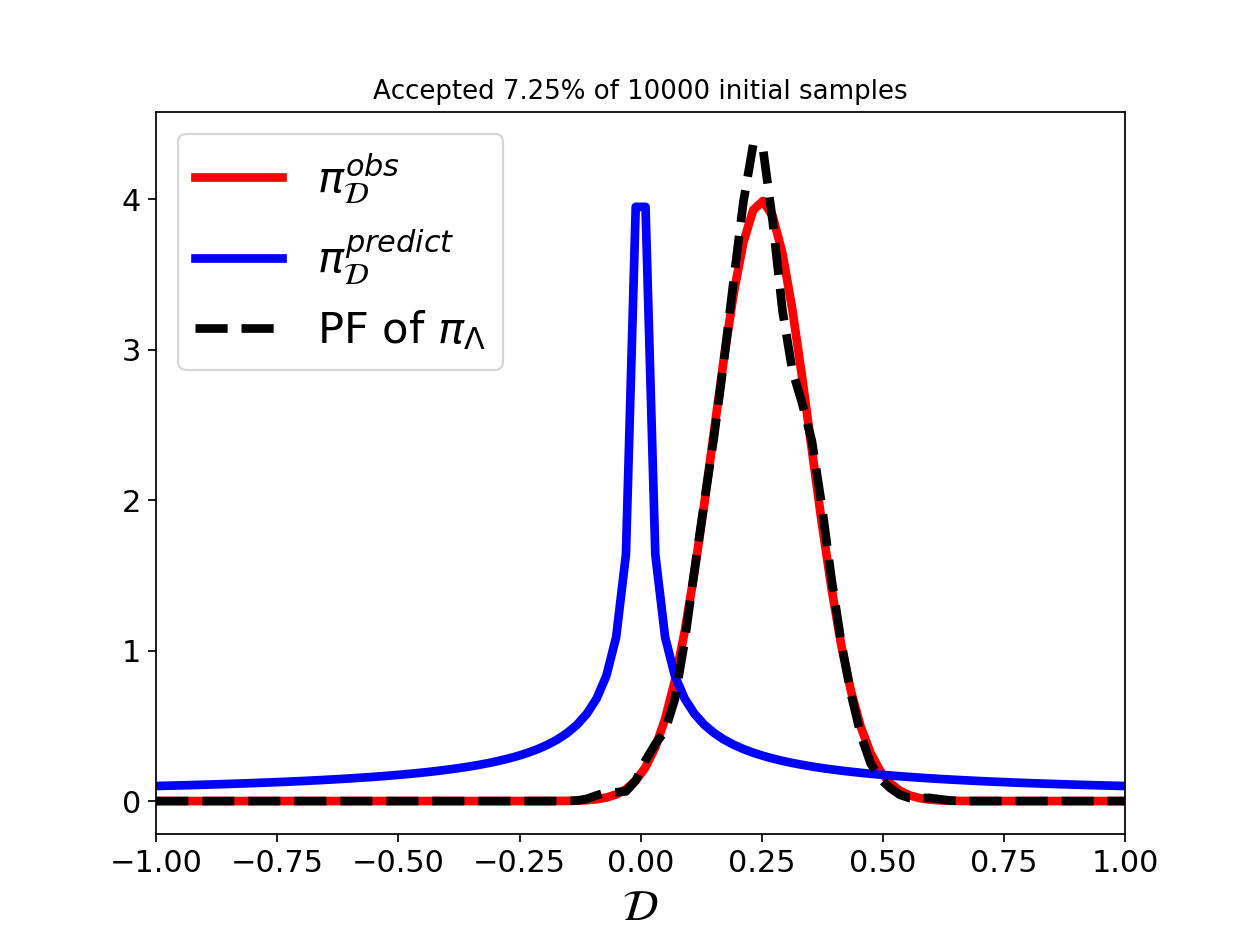

In [9]:
plt.figure(figsize=(8,6)) # Plot the push-forward of the initial, observed density, and push-forward of pullback
qplot = np.linspace(-1,1, num=100)
observed_plot = plt.plot(qplot,norm.pdf(qplot, loc=mu, scale=sigma), 'r-', linewidth=4, label="$\pi_\mathcal{D}^{obs}$")
pf_initial_plot = plt.plot(qplot,1/10*np.abs(qplot)**(-4/5),'b-', linewidth=4, label="$\pi_\mathcal{D}^{predict}$")
pf_post_plot = plt.plot(qplot,postq_nl_kde(qplot),'k--', linewidth=4, label="PF of $\pi_\Lambda$")
plt.xlim([-1,1]), plt.xlabel("$\mathcal{D}$", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
title_str = 'Accepted %4.2f' %(post_q_nonlinear.size/N*100) +'% of ' + str(N) + ' initial samples'
plt.title(title_str), plt.show();

### <center> A simple example in Python: Evaluating the solution
___
    
#### Quality of solution? 

* Statistics on $\pi_\Lambda$ are easily estimated using the accepted sample set, but it is <font color='red'>***unusual to know what the mean or standard deviation of $\pi_\Lambda$ should be***</font>.

* <font color='purple'>***We know what statistics <font color='red'>should be</font> on the push-forward of $\pi_\Lambda$.***</font>
  
    * Check by computing sample statistics on accepted samples.    

In [10]:
printmd('<font size=6pt>**$\mathbb{E}$(pf of $\pi_\Lambda$) = %4.3f**' %np.mean(post_q_nonlinear) + '  <font size=6pt>**vs. $\mathbb{E}(\pi_\mathcal{D}^{obs}$) = %4.3f**' %mu) # Should be about mu
printmd('<font size=6pt>**St. dev. of pf of $\pi_\Lambda$ = %4.3f**' %np.std(post_q_nonlinear) + '  <font size=6pt>**vs. St. dev. of $\pi_\mathcal{D}^{obs}$ = %4.3f**' %sigma)

<font size=6pt>**$\mathbb{E}$(pf of $\pi_\Lambda$) = 0.248**  <font size=6pt>**vs. $\mathbb{E}(\pi_\mathcal{D}^{obs}$) = 0.250**

<font size=6pt>**St. dev. of pf of $\pi_\Lambda$ = 0.096**  <font size=6pt>**vs. St. dev. of $\pi_\mathcal{D}^{obs}$ = 0.100**

### <center> A simple example in Python: Evaluating the solution
___
    
Statistics only tell part of the story. We should also check two things:

 - Did we satisfy the predictability assumption?
 
 
 - What did we gain by solving the inverse problem? (Use KL divergence, skipping in this talk but it is in the notebook)

### <center> A simple example in Python: Developing a diagnostic
___
#### Did we satisfy the predictability assumption?

Predictability assumption satisfied implies $\int_\Lambda \pi_\Lambda(\lambda)\, d\mu_\Lambda=1$, so

$$
     1 = \int_\Lambda \pi_\Lambda^{initial}(\lambda)r(Q(\lambda))\, d\mu_\Lambda = \int_\Lambda r(Q(\lambda))\, dP_\Lambda^{initial} = \mathbb{E}(r(Q(\lambda)))
$$

___
**<font color='purple'>Diagnostic for Verifying Predictability Assumption:</font>** ***Sample mean of $r(Q(\lambda))$ is approximately 1.***

Small deviations from 1 are usually expected and indicate finite sampling errors or errors in approximating $\pi_\mathcal{D}^{predict}$. (There are exceptions.) What was our sample mean?

In [11]:
printmd('<font size=8pt color=blue>**$\mathbb{E}(r) =$ %10.2f**' %(np.mean(r_nonlinear)) )

<font size=8pt color=blue>**$\mathbb{E}(r) =$       1.00**

### <center> A simple example in Python: Approximations and the diagnostic
___

* In general, we approximate $\pi_{\mathcal{D}}^{predict}$ with finite sampling and KDE (which introduces errors).

    * Let $\pi_{\mathcal{D},N}^{predict}$ and $\pi_{\Lambda,N}$ denote the resulting approximate PDFs.


* **<font color='purple'>Goal:</font>** Re-use samples generating $\pi_{\mathcal{D},N}^{predict}$ to generate samples from $\pi_\Lambda$. 

<IPython.core.display.Javascript object>


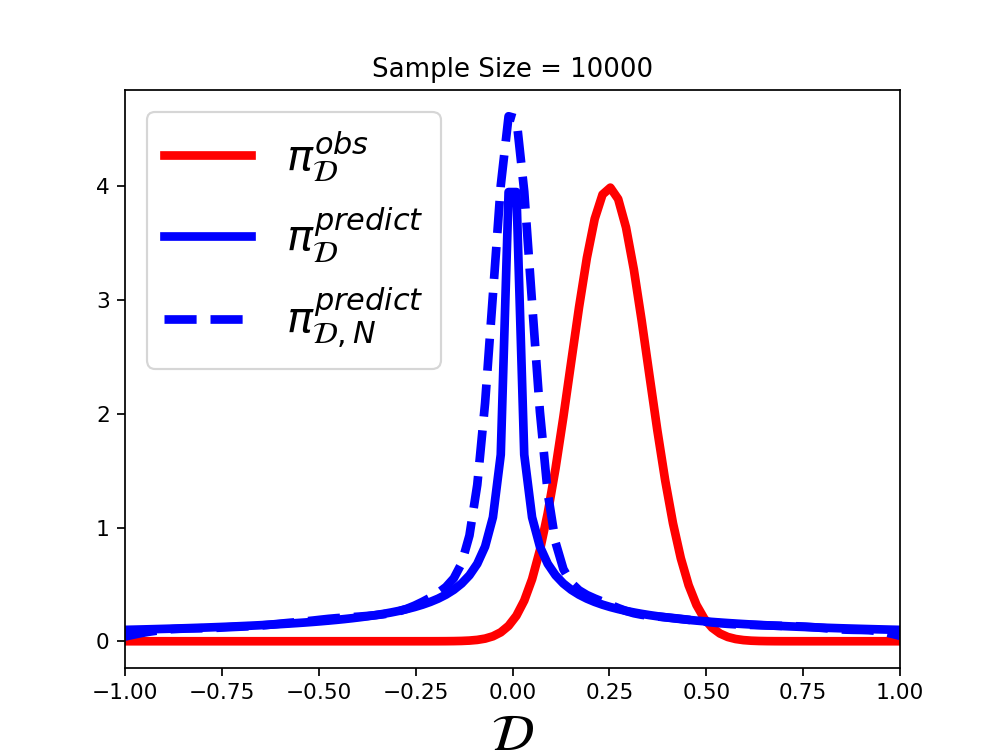

In [12]:
plt.figure() # Plot the push-forward of the initial and observed densities
qplot = np.linspace(-1,1, num=100)
observed_plot = plt.plot(qplot,norm.pdf(qplot, loc=mu, scale=sigma), 'r-', linewidth=4, label="$\pi_\mathcal{D}^{obs}$")
pf_initial_plot = plt.plot(qplot,1/10*np.abs(qplot)**(-4/5),'b-', linewidth=4, label="$\pi_\mathcal{D}^{predict}$")
pf_initial_plot = plt.plot(qplot,q_nonlinear_kde(qplot),'b--', linewidth=4, label="$\pi_{\mathcal{D},N}^{predict}$")
plt.xlim([-1,1]), plt.xlabel("$\mathcal{D}$", fontsize=24), plt.legend(fontsize=20), plt.title('Sample Size = ' + str(N)), plt.show();

In [13]:
# Compute approximate r using approx pf and compute its mean
r_nonlinear_approx = np.divide(obs_vals_nonlinear,q_nonlinear_kde(qvals_nonlinear))
#print(np.mean(r_nonlinear_approx))
printmd('<font size=6pt>**Using $\pi_{\mathcal{D},N}^{predict}$, $\mathbb{E}(r) =$ %10.2f**' %(np.mean(r_nonlinear_approx)) )

<font size=6pt>**Using $\pi_{\mathcal{D},N}^{predict}$, $\mathbb{E}(r) =$       0.93**

In [14]:
# Perform rejection sampling
samples_to_keep_nonlinear = rejection_sampling(r_nonlinear_approx)
post_lam_nonlinear = lam[samples_to_keep_nonlinear]

# Construct push-forward of the pullback density
post_q_nonlinear = qvals_nonlinear[samples_to_keep_nonlinear] 
postq_nl_kde = kde( post_q_nonlinear ) 

<IPython.core.display.Javascript object>


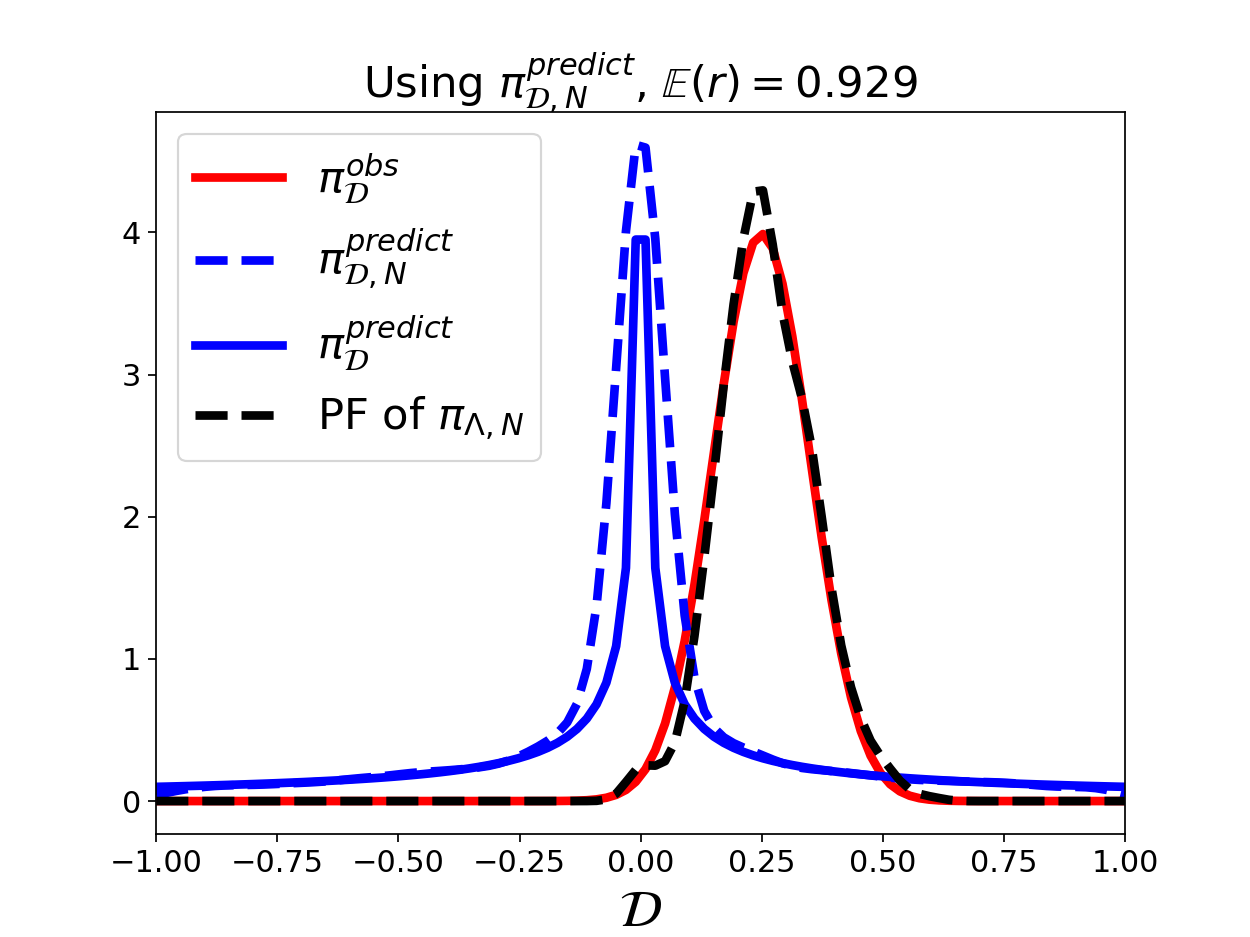

In [15]:
plt.figure(figsize=(8,6)) # Plot the push-forward of the initial, observed density, and push-forward of pullback
qplot = np.linspace(-1,1, num=100)
observed_plot = plt.plot(qplot,norm.pdf(qplot, loc=mu, scale=sigma), 'r-', linewidth=4, label="$\pi_\mathcal{D}^{obs}$")
approx_pf_initial_plot = plt.plot(qplot,q_nonlinear_kde(qplot),'b--', linewidth=4, label="${\pi}_{\mathcal{D},N}^{predict}$")
pf_initial_plot = plt.plot(qplot,1/10*np.abs(qplot)**(-4/5),'b-', linewidth=4, label="$\pi_\mathcal{D}^{predict}$")
pf_post_plot = plt.plot(qplot,postq_nl_kde(qplot),'k--', linewidth=4, label="PF of $\pi_{\Lambda,N}$")

title_str = 'Using $\pi_{\mathcal{D},N}^{predict}$, $\mathbb{E}(r) =$%2.3f' %(np.mean(r_nonlinear_approx))
plt.title(title_str, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-1,1]), plt.xlabel("$\mathcal{D}$", fontsize=24), plt.legend(fontsize=20), plt.show();

### <center> A simple example in Python: Information gain
___

#### What did we gain by solving the inverse problem?

***<font color='blue'>Information gain</font>*** quantified by the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (KL divergence)
\begin{eqnarray*}
    KL(\pi_{\Lambda}^{post} \, : \, \pi_{\Lambda}^{initial}) &=& \int_\Lambda \pi_\Lambda^{post}(\lambda)\log\left(\frac{\pi_\Lambda^{post}(\lambda)}{\pi_\Lambda^{initial}(\lambda)}\right)\, d\mu_\Lambda \\ &=& \int_\Lambda r(Q(\lambda))\log r(Q(\lambda))\, dP_\Lambda^{initial}.
\end{eqnarray*}

**<font color='purple'> Understanding the KL divergence:</font>**
$KL(\pi_{\Lambda}^{post} \, : \, \pi_{\Lambda}^{initial}) \geq 0$.
* Larger values indicate the posterior differs more significantly from the initial. 
        
* Different initials or different QoI maps clearly can impact the KL divergence.

In [16]:
print(np.mean(r_nonlinear*np.log(r_nonlinear)))

2.0004983448711475


### <center> A simple example in Python: Solving multiple inverse problems
___

#### Investigating different observed densities

Once  $\pi_\mathcal{D}^{predict}$ is constructed, $\pi_\Lambda$ is trivial to define for any observed density <font color='purple'>***as long as the predictability assumption holds.***</font> 

By **<font color='blue'>trivial</font>**, we mean that formulating $\pi_\Lambda$ does <font color='purple'>***not require any additional model solves.***</font>

In [17]:
# New observed density centered at 0
obs_vals_nonlinear_new = norm.pdf(qvals_nonlinear, loc=-0.6, scale=0.1) 
# Compute r
r_nonlinear_new = np.divide(obs_vals_nonlinear_new,q_nonlinear_kde(qvals_nonlinear))
print(np.mean(r_nonlinear_new))
# Rejection sampling
samples_to_keep_nonlinear_new = rejection_sampling(r_nonlinear_new)
post_lam_nonlinear_new = lam[samples_to_keep_nonlinear_new]
# Approximate the push-forward of pullback
post_q_nonlinear_new = qvals_nonlinear[samples_to_keep_nonlinear_new]
postq_nonlinear_new_kde = kde( post_q_nonlinear_new )

0.9947864979809732


<IPython.core.display.Javascript object>


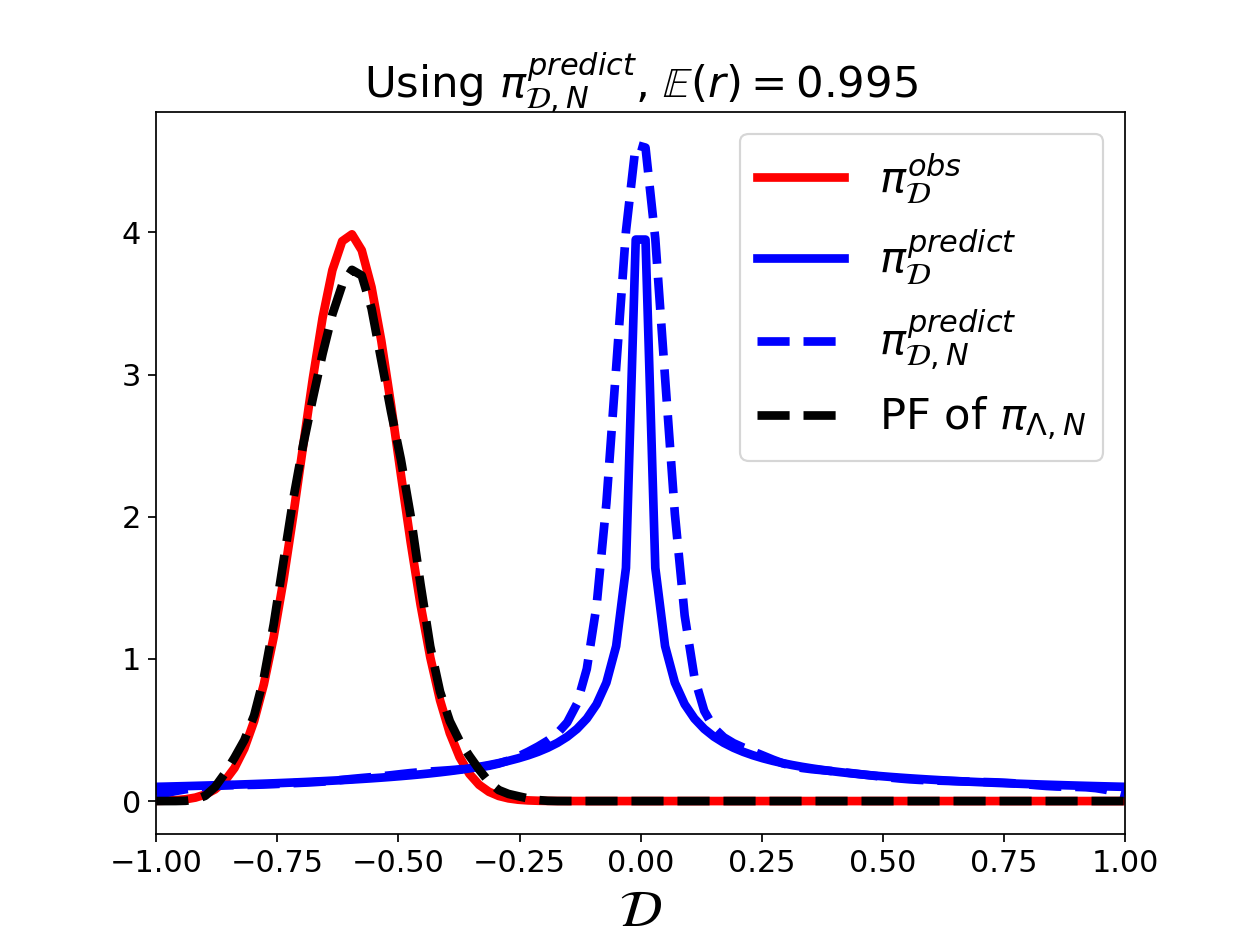

In [18]:
plt.figure(figsize=(8,6)) 
qplot = np.linspace(-1,1, num=100)
observed_plot = plt.plot(qplot,norm.pdf(qplot, loc=-0.6, scale=0.1), 'r-', linewidth=4, label="$\pi_\mathcal{D}^{obs}$")
pf_initial_plot = plt.plot(qplot,1/10*np.abs(qplot)**(-4/5),'b-', linewidth=4, label="$\pi_\mathcal{D}^{predict}$")
pf_initial_plot = plt.plot(qplot,q_nonlinear_kde(qplot),'b--', linewidth=4, label="$\pi_{\mathcal{D},N}^{predict}$")
pf_post_plot = plt.plot(qplot,postq_nonlinear_new_kde(qplot),'k--', linewidth=4, label="PF of $\pi_{\Lambda,N}$")
title_str = 'Using $\pi_{\mathcal{D},N}^{predict}$, $\mathbb{E}(r) =$%2.3f' %(np.mean(r_nonlinear_new))
plt.title(title_str, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-1,1]), plt.xlabel("$\mathcal{D}$", fontsize=24), plt.legend(fontsize=20), plt.show();

In [19]:
# New observed density centered at 0
obs_vals_nonlinear_new = norm.pdf(qvals_nonlinear, loc=1, scale=0.1) 
# Compute r
r_nonlinear_new = np.divide(obs_vals_nonlinear_new,q_nonlinear_kde(qvals_nonlinear))
print(np.mean(r_nonlinear_new))
# Rejection sampling
samples_to_keep_nonlinear_new = rejection_sampling(r_nonlinear_new)
post_lam_nonlinear_new = lam[samples_to_keep_nonlinear_new]
# Approximate the push-forward of pullback
post_q_nonlinear_new = qvals_nonlinear[samples_to_keep_nonlinear_new]
postq_nonlinear_new_kde = kde( post_q_nonlinear_new )

0.5886070651895102


<IPython.core.display.Javascript object>


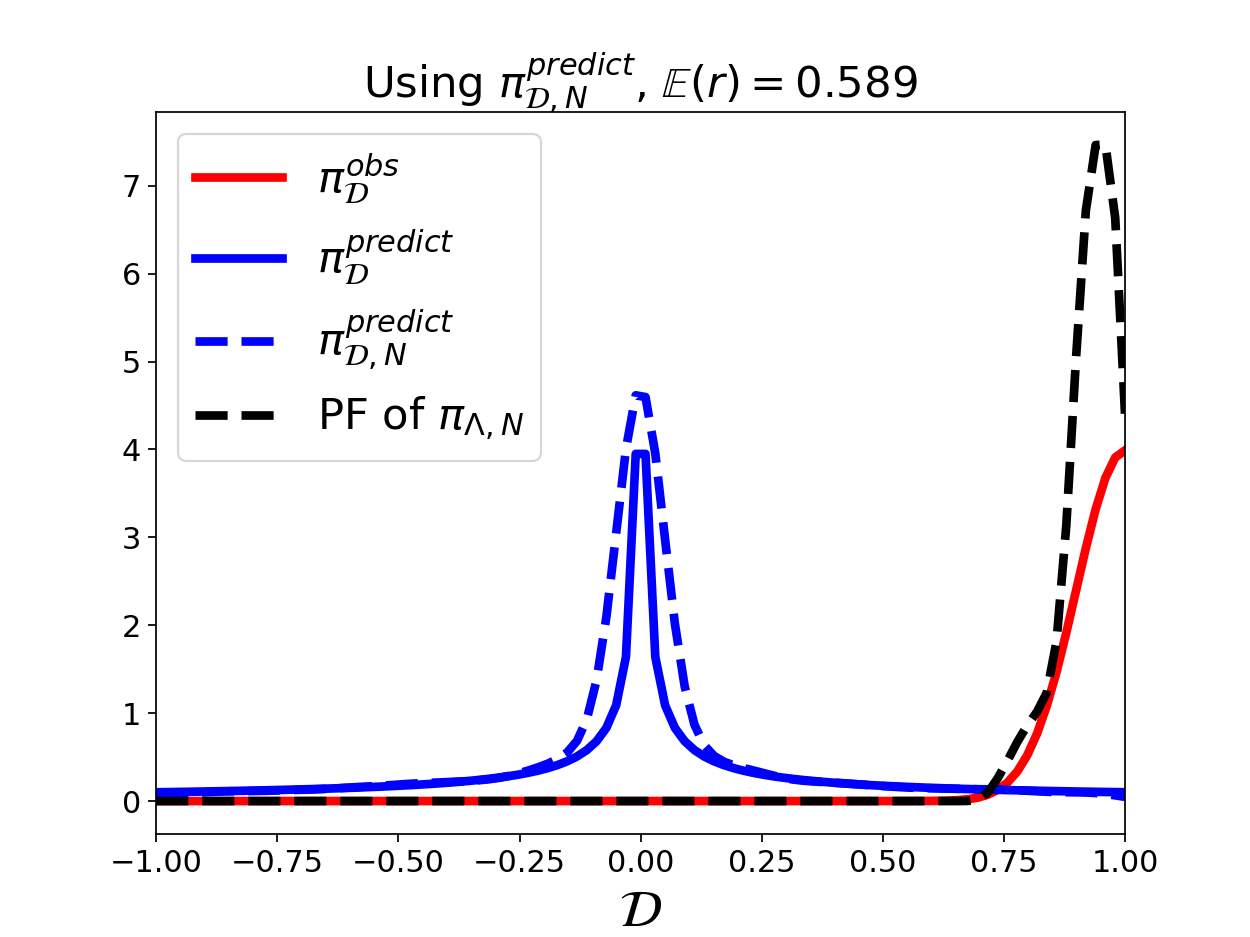

In [20]:
plt.figure(figsize=(8,6)) 
qplot = np.linspace(-1,1, num=100)
observed_plot = plt.plot(qplot,norm.pdf(qplot, loc=1, scale=0.1), 'r-', linewidth=4, label="$\pi_\mathcal{D}^{obs}$")
pf_initial_plot = plt.plot(qplot,1/10*np.abs(qplot)**(-4/5),'b-', linewidth=4, label="$\pi_\mathcal{D}^{predict}$")
pf_initial_plot = plt.plot(qplot,q_nonlinear_kde(qplot),'b--', linewidth=4, label="$\pi_{\mathcal{D},N}^{predict}$")
pf_post_plot = plt.plot(qplot,postq_nonlinear_new_kde(qplot),'k--', linewidth=4, label="PF of $\pi_{\Lambda,N}$")
title_str = 'Using $\pi_{\mathcal{D},N}^{predict}$, $\mathbb{E}(r) =$%2.3f' %(np.mean(r_nonlinear_new))
plt.title(title_str, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-1,1]), plt.xlabel("$\mathcal{D}$", fontsize=24), plt.legend(fontsize=20), plt.show();

### <center> A statistical Bayesian perspective
___

$$
    {\pi}_\Lambda(\lambda \, | \, q) = \pi_\Lambda^{initial}\frac{ L(q\, |\,  \lambda) }{C}
$$

 * $L(q\, | \, \lambda)$ is a ***data likelihood*** function that is not necessarily the same as the observed density.


 * $C$ is a normalizing constant.
 
     * Usually not important when generating samples from the posterior using MCMC.
     
     * We compute it only so we can compare to our posterior by using rejection sampling.
 

### <center> A simple example in Python: Comparison to statistical Bayesian
___

We use the same initial and make the data likelihood function match the observed density.

In [21]:
# compute normalizing constants
C_nonlinear = np.mean(obs_vals_nonlinear)
sbayes_r_nonlinear = obs_vals_nonlinear/C_nonlinear

# Perform rejection sampling
sbayes_samples_to_keep_nonlinear = rejection_sampling(sbayes_r_nonlinear)
sbayes_post_lam_nonlinear = lam[sbayes_samples_to_keep_nonlinear]

# Construct push-forward of statistical Bayesian posterior
sbayes_post_q_nonlinear = qvals_nonlinear[sbayes_samples_to_keep_nonlinear]
sb_postq_nl_kde = kde( sbayes_post_q_nonlinear )

<IPython.core.display.Javascript object>


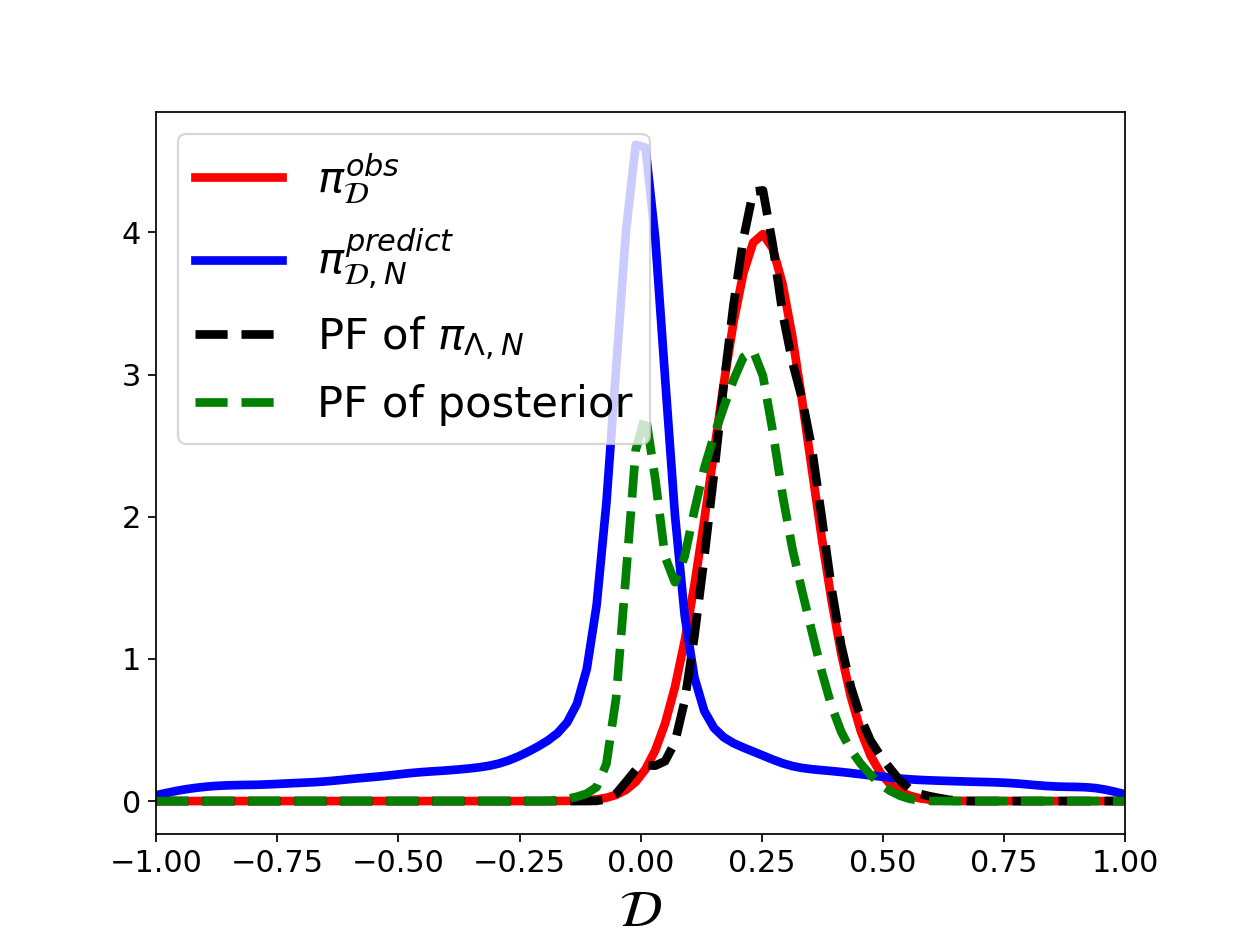

In [22]:
plt.figure(figsize=(8,6)) # Plot the push-forward of the initial, observed density, and push-forward of pullback and stats posterior
qplot = np.linspace(-1,1, num=100)
observed_plot = plt.plot(qplot,norm.pdf(qplot, loc=mu, scale=sigma), 'r-', linewidth=4, label="$\pi_\mathcal{D}^{obs}$")
pf_initial_plot = plt.plot(qplot,q_nonlinear_kde(qplot),'b-', linewidth=4, label="$\pi_{\mathcal{D},N}^{predict}$")
pf_post_plot = plt.plot(qplot,postq_nl_kde(qplot),'k--', linewidth=4, label="PF of $\pi_{\Lambda,N}$")
pf_sb_post_plot = plt.plot(qplot,sb_postq_nl_kde(qplot),'g--', linewidth=4, label="PF of posterior")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-1,1]), plt.xlabel("$\mathcal{D}$", fontsize=24), plt.legend(fontsize=20), plt.show();

<a id='Dimension'></a>
### <center> Discretized PDE Example
___
<font color='gray'>
\begin{equation*}
\begin{cases}
-\nabla \cdot (K(\lambda) \nabla u) = 0, & (x,y)\in\Omega = (0,1)^2,\\
u = 1, & x=0, \\
u = 0, & x=1, \\
K(\lambda)\nabla p \cdot \mathbf{n} = 0, & y=0 \text{ and } y=1.
\end{cases}
\end{equation*}
    </font>

<br>

<center><font color='gray'>Diffusion field defined by $Y = \log{K}$ and $Y(\lambda) = \overline{Y} + \sum_{i=1}^\infty \xi_i(\lambda)\sqrt{\eta_i}f_i(x,y)$.</font> </center>

<br>

<center> <font color='blue'>Truncate KL expansion at 100 terms and use $\pi_\Lambda^{initial}\sim N(0,I)$.</font> </center>
   

### <center> Are we really going to perform accept/reject in 100D?
___
    
No! The computations are really taking place in the 1D data space!

In [23]:
data_set = sio.loadmat('elliptic_kde100_10K.mat')
qvals = data_set['qq'] # QoI samples
qvals = qvals[:,0] # Only using first QoI here
lam_100D = data_set['pp'] # parameter samples

In [24]:
obs_vals = norm.pdf(qvals, loc=0.7, scale=1.0e-2) # Define an observed density
q_kde = kde( qvals, 'silverman' )

r = np.divide(obs_vals,q_kde(qvals))
print(np.mean(r))

samples_to_keep = rejection_sampling(r)
post_lam_100D = lam_100D[:,samples_to_keep]
post_q = qvals[samples_to_keep]
post_q_kde = kde(post_q)
accept_rate = samples_to_keep.size/lam.shape[0]
print(accept_rate)

0.9967766306208632
0.2744


<IPython.core.display.Javascript object>


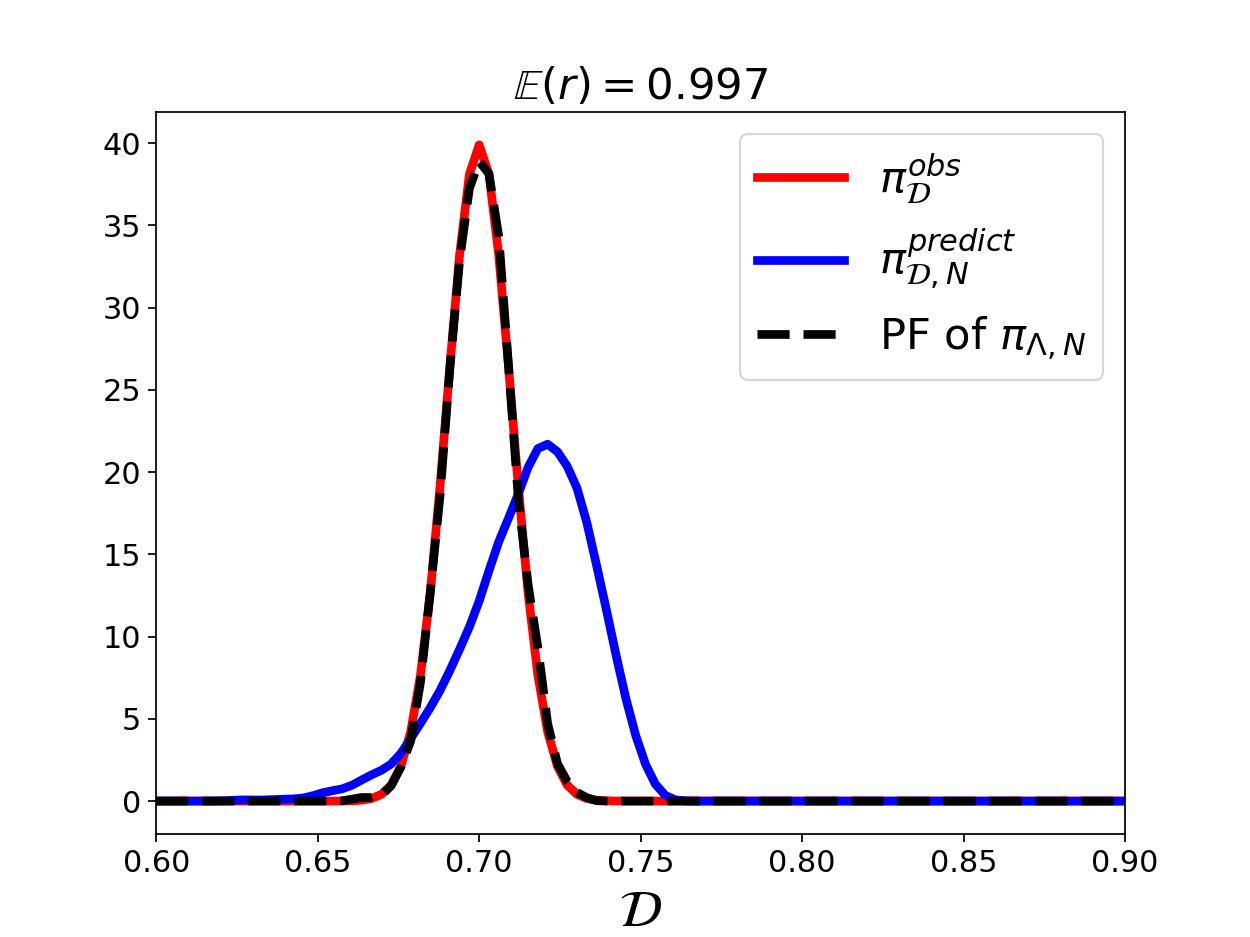

In [25]:
plt.figure(figsize=(8,6)) # Plot data space densities
qplot = np.linspace(0.6, 0.9, num=100) 
postq_kde = kde( post_q, 'silverman' )

oplot = plt.plot(qplot,norm.pdf(qplot, loc=0.7, scale=1.0e-2), 'r-', linewidth=4, label="$\pi_\mathcal{D}^{obs}$")
prplot = plt.plot(qplot,q_kde(qplot),'b-', linewidth=4, label="$\pi_{\mathcal{D},N}^{predict}$")
poplot = plt.plot(qplot,post_q_kde(qplot),'k--', linewidth=4, label="PF of $\pi_{\Lambda,N}$")

title_str = '$\mathbb{E}(r) =$%2.3f' %(np.mean(r))
plt.title(title_str, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0.6,0.9]), plt.xlabel("$\mathcal{D}$", fontsize=24), plt.legend(fontsize=20), plt.show();

<IPython.core.display.Javascript object>


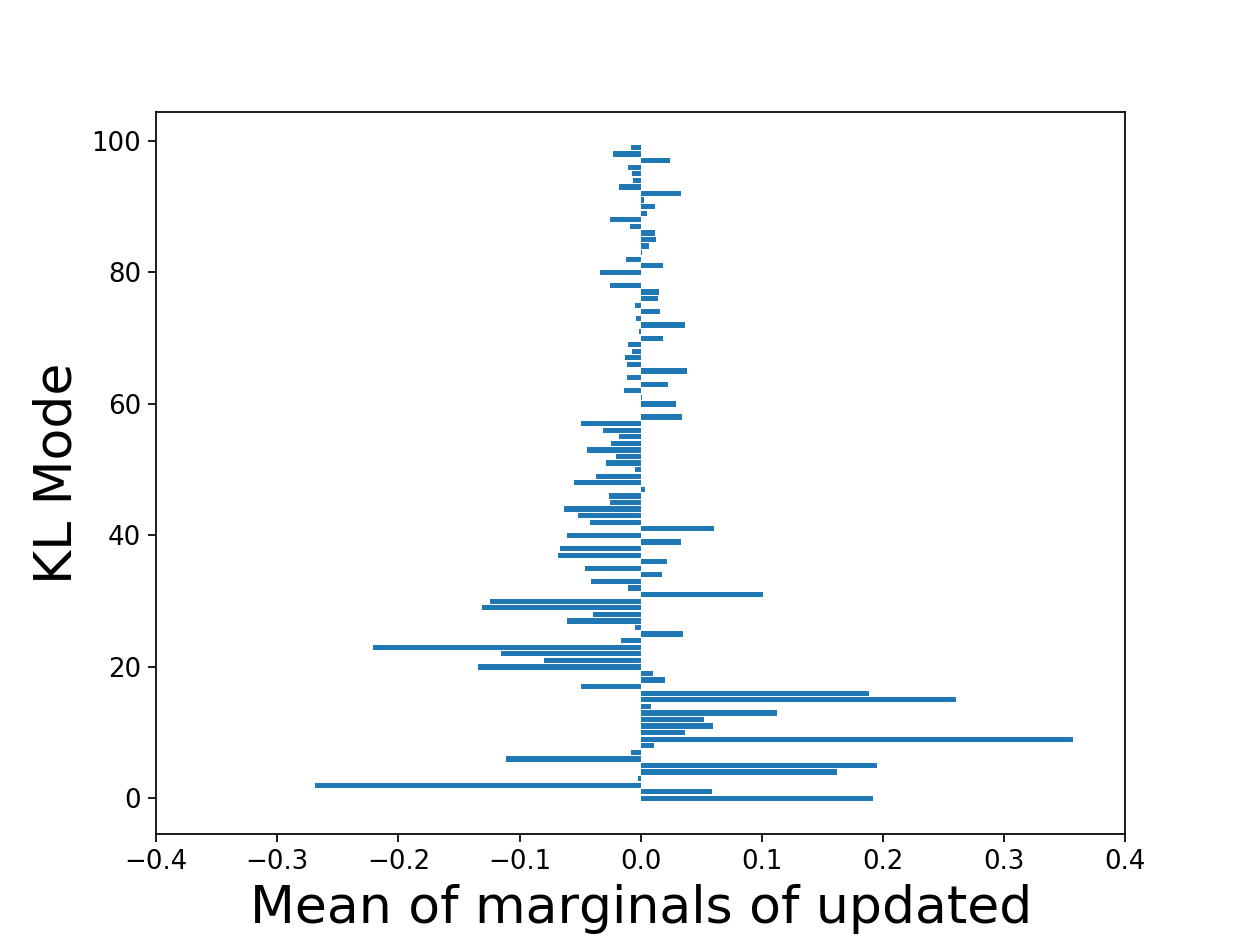

In [26]:
plt.figure(figsize=(8,6)) # Visualize posterior statistics in 100-D
param = np.arange(100)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.barh(param,np.mean(post_lam_100D,1)), plt.xlim([-0.4,0.4]), plt.xlabel("Mean of marginals of updated", fontsize=24)
plt.ylabel("KL Mode", fontsize=24), plt.show();

### <center> How well do we scale with dimension?
___
    

It all depends on which space $\Lambda$ or $\mathcal{D}$ has the **large** dimension.

### <center> Convergence and Dimension: An Example
___
   
***Setup:***

$
	Q(\lambda) = (\lambda-\mu)^\top C^{-1}(\lambda-\mu),
$

$
	\pi_{\mathcal{D}}^\text{obs}\sim U([a,b])^*
$

<br>

***Prior and Push-forward:***

$
	\boxed{\Lambda = \mathbb{R}^{{d}}} \ \text{ and } \  \pi_\Lambda^{initial} \sim N(\mu, C) \ \Rightarrow \ \pi_{\mathcal{D}}^{predict} \sim \chi^2(d)
$
--

---
$^*$ $a$ and $b$ chosen as the $40$th and $60$th percentiles of $\pi_{\mathcal{D}}^{predict}$ for each $d$

### <center> Approx. error in $L^1$ of updated density vs. Num. Samples used in GKDE.
___
    
  
<center><img src="figures/convergence_linearQ_paramDim_d_vs_samples.png" width=70%/> 

### <center> Convergence and Dimension: An Example
___
   
***Setup:***

$
    \boxed{Q\in\mathbb{R}^{{m}}}, 	Q_i(\lambda) = (\lambda-\mu_i)^\top C_i^{-1}(\lambda_i-\mu),
$
--
$
	\pi_{\mathcal{D}}^\text{obs}\sim U([a,b])^*
$

<br>

***Prior and Push-forward:***

$
	\Lambda = \mathbb{R}^{10}, \pi_\Lambda^{initial} \sim N(\mu, C) \Rightarrow \pi_{\mathcal{D}_i}^{predict} \sim \chi^2 (10/m)
$

---
$^*$ $a$ and $b$ chosen so Lebesgue measure of support of $\pi_{\mathcal{D}}^{obs}$ is constant for each $m$.

### <center> Approx. error in $L^1$ of updated density vs. Num. Samples used in GKDE.
___
    
<center><img src="figures/convergence_linearQ_QDim_m_vs_samples.png" width=70%/> 

### <center> So how do we address our curse of dimensionality?
---
    
Really the topic for a completely different talk and involves on-going research on density-free approaches to data-consistent inversion. 

### <center> Summary up to this point
---
   
* The data-consistent solution exists, is unique (up to choice of  $\pi_\Lambda^{initial}(\lambda)$), and is stable.

   
* The data-consistent solution is an update to $\pi_\Lambda^{initial}(\lambda)$ only in directions locally orthogonal to set-valued inverses.


* All computations take place in the (generally) lower-dimensional QoI space.

    * Rejection sampling is often possible even if parameter spaces are high-dimensional.
    

* The ratio $r(Q(\lambda))$ provides a useful diagnostic for verifying predictability assumption, performing rejection sampling, and is the critical component distinguishing this approach from classical Bayesian formulations of inverse problems.

### <center> From data to QoI
___

    
<font color='blue'><center>***Data is like garbage. You'd better know what you are going to do with it before you collect it.*** - *Mark Twain*</center></font>
<br>
    
- We have so far assumed that observable data is for some a priori specified QoI.

- What if we collect data but we do <font color='red'>**not**</font> know the QoI?

- Data is *not* the same thing as information and by itself is *not* interesting. 

- In the era of *Big Data*, we often collect a lot of garbage and then go dumpster diving. Our apologies to Mark Twain.

### <center> From data to QoI: Illustrative example
___

- $\Lambda = [-1,1]^2\subset\mathbb{R}^2$

- Dynamic response induced by parameters given by polynomial of unknown order.
    
- Observed data obtained at 10 Hz $[0,2]$ ($t$ assumed in seconds).

In [27]:
def poly(t, lam):
    poly_order = np.random.choice([2, 3, 4, 5, 6], 1)[0]  # Randomly choose a 2nd to 6th order poly
    print(poly_order)
    num_params = lam.shape[0]
    num_t = len(t)
    p_vals = np.zeros( (num_params, num_t) )
    for j in range(poly_order-1):
        p_vals[:, :] += (2*np.random.uniform()-1)* t**j
    for i in range(num_params):
        p_vals[i, :] += lam[i,0] * t**(poly_order-1) + lam[i,1] * t**(poly_order)
    return p_vals

In [28]:
N = int(1e3)
lam = np.random.uniform(low=-1, high=1, size=(N,2))
t = np.linspace(0, 2, 21)
data = poly(t[1:], lam)

3


<IPython.core.display.Javascript object>


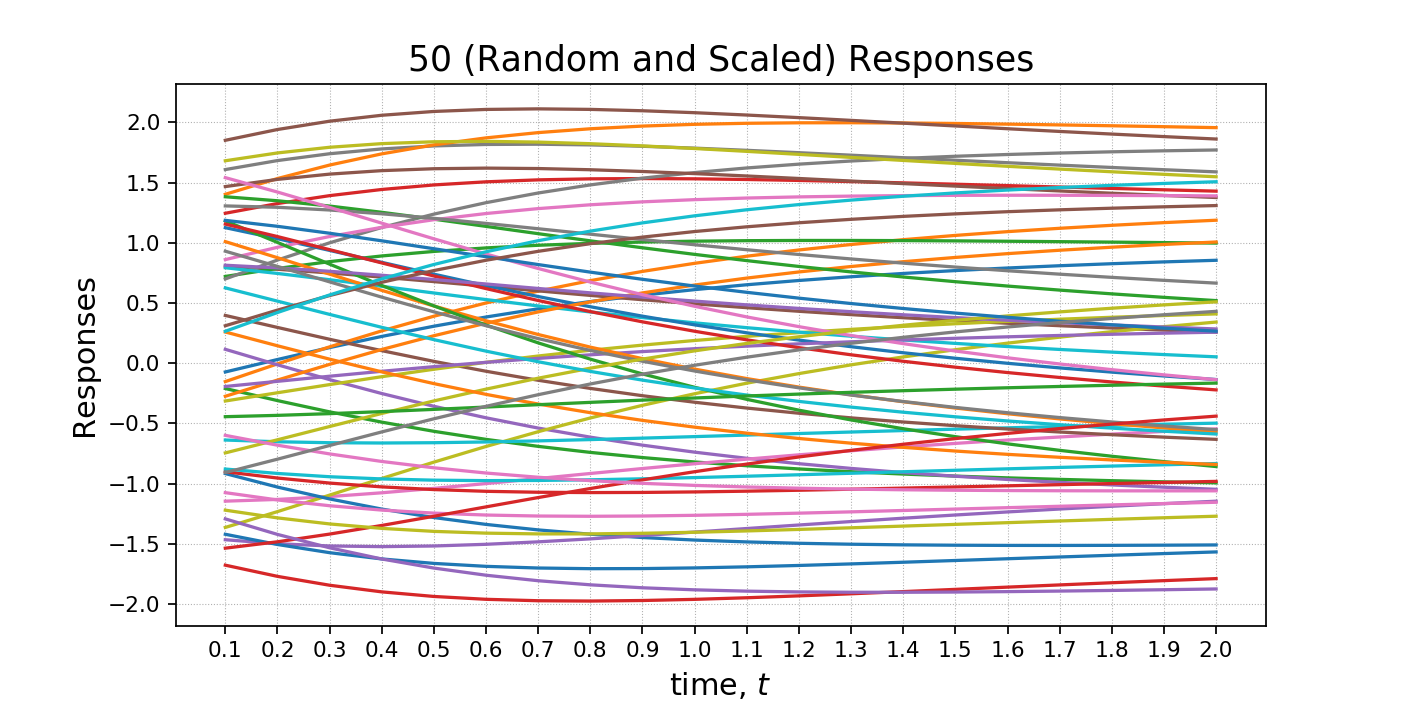

Text(0.5, 1.0, '50 (Random and Scaled) Responses')

In [41]:
data_scaled = StandardScaler().fit_transform(data) # scaling the samples


plt.figure(figsize=(9,4.5))
plt.plot(t[1:], data_scaled.T[:,np.random.choice(N,50)]);
plt.xlabel('time, $t$', fontsize=14)
plt.ylabel('Responses', fontsize=14)
plt.xticks(t[1:])
plt.grid(True, linestyle=':', lw='0.5')
plt.title('50 (Random and Scaled) Responses', fontsize=16)

In [30]:
pca = PCA(n_components=20) # initializing PCA
principal_components = pca.fit_transform(data_scaled)

### <center> From data to QoI: Illustrative example
___

- Use PCA to <font color='blue'>***learn***</font> the number of interesting features in the data. 

In [40]:
%reset -f out

def plot_gap(eig_vals, n):
    fig = plt.figure(figsize=(9,4.5))
    fig.clear()
    plt.semilogy(np.arange(1,1+np.size(eig_vals)),eig_vals, Marker='o', MarkerSize=12, linestyle='')
    plt.semilogy(np.arange(0,2+np.size(eig_vals)),eig_vals[n]*np.ones(np.size(eig_vals)+2), 'r--')
    plt.semilogy(np.arange(0,2+np.size(eig_vals)),eig_vals[n+1]*np.ones(np.size(eig_vals)+2), 'r--')
    s = 'Orders of magnitude between %d and %d e.vals is %4.2f' %(n+1, n+2, 
                                                                  np.log10(eig_vals[n])-np.log10(eig_vals[n+1]))
    s += '\n and e.vals up to %d account for %4.2f percent of variation' %(n+1, 
                                                                           np.sum(eig_vals[0:n+1])/np.sum(eig_vals)*100)
    plt.title(s)
    plt.xticks(np.arange(1, len(eig_vals)+1))
    plt.grid(True, linestyle=':', lw=0.5);

interact(plot_gap,
         eig_vals = widgets.fixed(pca.singular_values_),
         n = widgets.IntSlider(value=1, min=0, max=5));

Flushing output cache (0 entries)


interactive(children=(IntSlider(value=1, description='n', max=5), Output()), _dom_classes=('widget-interact',)…

### <center> From data to QoI: Illustrative example
___

- Construct the QoI map $Q(\lambda)$ from what we learned.

<IPython.core.display.Javascript object>


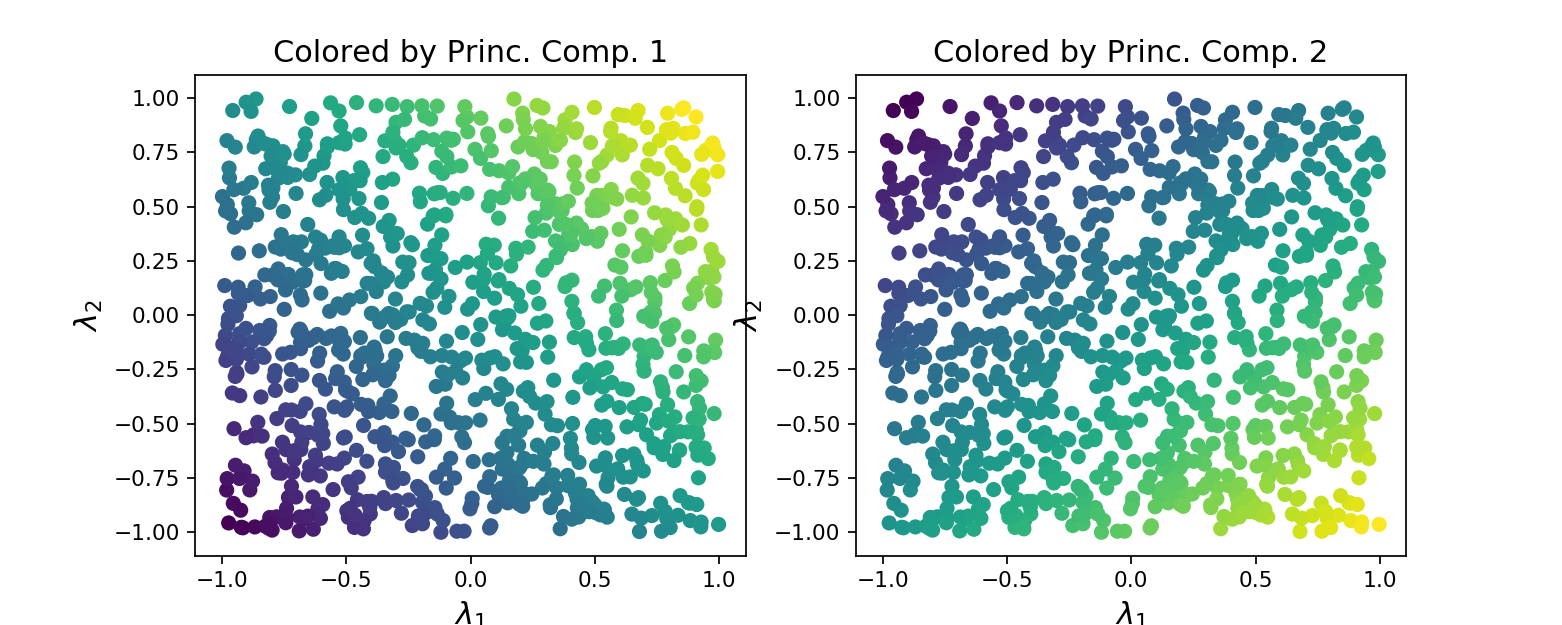

Text(0.5, 1.0, 'Colored by Princ. Comp. 2')

In [43]:
## principal components plot ##
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(lam[:,0], lam[:,1], c = principal_components[:,0])
plt.xlabel("$\lambda_1$", fontsize=14)
plt.ylabel("$\lambda_2$", fontsize=14)
plt.title("Colored by Princ. Comp. 1", fontsize=14)

plt.subplot(1,2,2)
plt.scatter(lam[:,0], lam[:,1], c=principal_components[:,1])
plt.xlabel("$\lambda_1$", fontsize=14)
plt.ylabel("$\lambda_2$", fontsize=14)
plt.title("Colored by Princ. Comp. 2", fontsize=14)

### <center> Then what? (and many additional "what ifs")
___

- Proceed as usual ***after*** transforming all time series of data (predicted and observed) into samples of QoI from which $\pi_\mathcal{D}^{predict}$ and $\pi_\mathcal{D}^{obs}$ can be estimated.

- But, **what if** the responses had no closed form (i.e., there is *no* polynomial), and **what if** all we have are noisy measurements with uncertain levels of noise, and **what if** bifurcations occur in the dynamical response as parameters vary in ways that are not known a priori, and **what if** the noisy observable data and computational data are available at potentially different frequencies, and **what if** these data have differing levels of noise, and **what if** there were potentially missing data values in a given time window?

- Well, then we are in [`LUQ`](https://github.com/CU-Denver-UQ/LUQ)!

### <center> Learning Uncertain Quantities ([`LUQ`](https://github.com/CU-Denver-UQ/LUQ)) is as easy as 1-2-3
___
    
- Step 1: Filter data (approximating dynamics) with adaptive piecewise linear splines
<br>

- Step 2: Clustering and classifying data (learning and classifying dynamics)
<br>

- Step 3: Feature extraction (learning quantities of interest)

### <center> A typical LUQ implementation
___
    
Step 0: Create a LUQ object (the hidden step)

`from luq import LUQ  # Import LUQ module`<br>
`learn = LUQ(predicted_time_series, observed_time_series, times)`

- Step 1: `learn.filter_data(**kwargs)`
<br>

- Step 2: `learn.dynamics(**kwargs)`
<br>

- Step 3: `predict_qoi, obs_qoi = learn.learn_qois_and_transform(**kwargs)`

### <center> A simple example (harmonic oscillator): Step 1
___

<center>           |  <center>
:-------------------------:|:-------------------------:
<img src="figures/harmonic-oscillator-approximating-dynamics.png" width=100%/>   |  <img src="figures/harmonic-oscillator-cleaning-data.png" width=100%/> 

### <center> A simple example (harmonic oscillator): Step 2
___

<center>
<img src="figures/harmonic-oscillator-cluster-1.png" width=100%/> 

### <center> A simple example (harmonic oscillator): Step 3
___

<center>
<img src="figures/harmonic-oscillator-PCs-cluster-1.png" width=40%/>   

### <center> A simple example (harmonic oscillator): Updated densities on $c$ and $\omega_0$
___
    

<center>           |  <center>
:-------------------------:|:-------------------------:
<img src="figures/harmonic-oscillator-densities-c.png" width=80%/>   |  <img src="figures/harmonic-oscillator-densities-omega.png" width=80%/> 

### <center> Not so simple examples (15 minutes just isn't enough time)
___
    
    
_[***Learning Quantities of Interest from Dynamical Systems for Observation-Consistent Inversion***, Steven Mattis, Kyle Robert Steffen, Troy Butler, Clint N. Dawson, Donald Estep, arXiv:2009.06918v2](https://arxiv.org/abs/2009.06918)_ has several other examples of interfacing [`LUQ`](https://github.com/CU-Denver-UQ/LUQ) with observation/data-consistent inverse problems including 

- the Sel'kov model of glycolysis that exhibits a Hopf bifurcation as we vary kinetic parameters, 
<br>

- Burger's equation of a traveling wave exhibiting a shock forming at different speeds as we vary the initial condition, 
<br>

- the Advanced Circulation (ADCIRC) model for the shallow water equations modeling the variability of water elevations as a function of uncertain wind drag parameters during a simulated extreme weather event in the Shinnecock Inlet off the coast of Long Island, NY, USA.

### <center> Questions?
___
    
<center><img src="figures/dt160107.gif" width=70%>